In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

In [2]:
import os
os.environ["POLARS_MAX_THREADS"] = "10"

In [3]:
import polars as pl
import networkx as nx
from tqdm import tqdm

pl.Config.set_streaming_chunk_size(100_000)

edges_df = pl.scan_parquet('data/UrbanTrafficBenchmark/city_M_raw_edges.parquet')  # Lazy execution

def get_lazy_shape(lf):
    rows = lf.select(pl.len()).collect()[0,0]
    cols = len(lf.collect_schema().names())
    return (rows, cols)

print(get_lazy_shape(edges_df))
edges_df.head().collect()

(121236, 2)


source,target
i64,i64
0,7760
0,7761
1,5
2,6
3,7


Проверим, что пары рёбер встречаются только один раз

In [4]:
edges_df.group_by("source", "target").len().select("len").sort("len", descending=True).head().collect()

len
u32
1
1
1
1
1


In [5]:
print('Unique values in source:', edges_df.group_by("source").max().select(pl.len()).collect().item())
print('Unique values in target:', edges_df.group_by("target").max().select(pl.len()).collect().item())

Unique values in source: 53515
Unique values in target: 53515


In [6]:
features_df = pl.scan_parquet('data/UrbanTrafficBenchmark/city_M_static_features_modified.parquet')

def get_lazy_shape(lf):
    rows = lf.select(pl.len()).collect()[0,0]
    cols = len(lf.collect_schema().names())
    return (rows, cols)

print(get_lazy_shape(features_df))
features_df.head().collect()

(53530, 315)


category,edge_type,speed_mode,speed_limit,region_id,can_bind_to_reverse_edge,dismount_bike,has_masstransit_lane,ends_with_crosswalk,ends_with_toll_post,is_in_poor_condition,is_paved,is_restricted_for_trucks,is_toll,access_0,access_1,access_2,access_3,access_4,access_5,length,num_segments,x_coordinate_start,y_coordinate_start,x_coordinate_end,y_coordinate_end,node_id,speed_23:20:00,speed_03:25:00,speed_11:50:00,speed_07:25:00,speed_05:00:00,speed_01:25:00,speed_22:20:00,speed_13:20:00,speed_05:35:00,speed_14:50:00,…,speed_06:20:00,speed_23:50:00,speed_20:25:00,speed_04:55:00,speed_01:20:00,speed_17:20:00,speed_02:15:00,speed_04:10:00,speed_11:05:00,speed_23:10:00,speed_08:05:00,speed_21:55:00,speed_19:25:00,speed_04:20:00,speed_21:15:00,speed_08:55:00,speed_21:50:00,speed_06:55:00,speed_19:35:00,speed_04:00:00,speed_16:35:00,speed_16:30:00,speed_23:55:00,speed_13:40:00,speed_13:35:00,speed_14:30:00,speed_11:15:00,speed_09:45:00,speed_01:55:00,speed_20:40:00,speed_13:30:00,speed_05:45:00,speed_17:00:00,speed_08:30:00,speed_16:40:00,speed_13:45:00,speed_10:40:00
f64,f64,f64,f64,f64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
6.0,1.0,0.0,0.0,3.0,true,false,false,false,false,false,true,true,false,true,true,true,true,true,true,38.299999,1.0,60.379835,56.796346,60.379927,56.796687,"""node_0""",null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
6.0,1.0,0.0,0.0,3.0,true,false,false,false,false,false,true,true,false,true,true,true,true,true,true,310.200012,3.0,60.379835,56.796346,60.384792,56.796936,"""node_1""",null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
6.0,1.0,0.0,0.0,3.0,true,false,false,false,false,false,true,true,false,true,true,true,true,true,true,552.799988,7.0,60.379835,56.796346,60.386115,56.795037,"""node_2""",null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
6.0,1.0,0.0,0.0,3.0,true,false,false,false,false,false,true,true,false,true,true,true,true,true,true,97.599998,1.0,60.379835,56.796346,60.379655,56.795475,"""node_3""",null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
6.0,1.0,0.0,0.0,3.0,true,false,false,false,false,false,true,true,false,true,true,true,true,true,true,84.599998,2.0,60.379835,56.796346,60.378729,56.79589,"""node_4""",null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


Похоже, что `city_M_raw_edges` - это список сочленений рёбер. Потому что тут 53К уникальных значений по столбцам. Их почти столько же, сколько и в `city_M_static_features`, где записаны признаки для рёбер (в т.ч. координаты начала и окончания)

Получается, что в графе `city_M_raw_edges` конец ребра source имеет почти такие же координаты, как и начало ребра target. Проверим это

In [7]:
display(features_df.slice(0, 1).select('x_coordinate_end', 'y_coordinate_end',).collect())
features_df.slice(7760, 1).select('x_coordinate_start', 'y_coordinate_start',).collect()

x_coordinate_end,y_coordinate_end
f64,f64
60.379927,56.796687


x_coordinate_start,y_coordinate_start
f64,f64
60.379927,56.796687


Ура! Они совпадают, гипотеза верна

Посмотрим, какое ребро имеет больше всего сочленений. Посмотрим координаты его окончания на карте. Ожидается, что там будет сложный перекрёсток

In [8]:
top_edges_df = edges_df.group_by("source").len().sort("len", descending=True).head().collect()
display(top_edges_df)
edge_id = top_edges_df[0, 0]
features_df.slice(edge_id, 1).select('x_coordinate_start', 'y_coordinate_start',).collect()

source,len
i64,u32
32687,6
32680,6
32603,6
32639,6
32627,6


x_coordinate_start,y_coordinate_start
f64,f64
60.589692,56.896876


In [9]:
import folium

m = folium.Map(location=[56.896876, 60.589692])
folium.Marker(location=[56.896876, 60.589692], popup="Конец дороги, к которой примыкает много рёбер").add_to(m)
m

По ПДД к ней действительно примыкает 6 рёбер: 5 съездов + разворот

Посмотрим, сколько рёбер в каждом регионе

In [10]:
features_df.group_by("region_id").len().sort("len", descending=True).head(10).collect()

region_id,len
f64,u32
7.0,9299
5.0,7773
3.0,6311
2.0,5967
6.0,5641
24.0,5050
8.0,4347
4.0,4183
25.0,1765


Отлично. Попробуем нарисовать все рёбра для какого-то региона

In [11]:
m = folium.Map(location=[56.896876, 60.589692])

region_features_df = features_df.filter(
    pl.col("region_id") == 8.0
).collect()

for (
        x_coordinate_start, y_coordinate_start, x_coordinate_end, y_coordinate_end
    ) in region_features_df[:, ['x_coordinate_start', 'y_coordinate_start', 'x_coordinate_end', 'y_coordinate_end']].iter_rows():
    line = folium.PolyLine(locations=[
        (y_coordinate_start, x_coordinate_start),
        (y_coordinate_end, x_coordinate_end)
    ], color='blue', weight=5, opacity=0.8)
    line.add_to(m)
m

Супер. Теперь загрузим разметку на скорости движения на рёбрах

Я сразу добавил колонку с timestamp в int - её дорого вычислять на лету в LazyDataFrame. При фильтрации по datetime вылезают приколы, связанные с проталкиванием представления в parquet движок

In [12]:
speed_df = pl.scan_parquet('data/UrbanTrafficBenchmark/city_M_raw_speed_modified.parquet')

def get_lazy_shape(lf):
    rows = lf.select(pl.len()).collect()[0,0]
    cols = len(lf.collect_schema().names())
    return (rows, cols)

def get_first_last_columns(df, n=10):
    cols = df.collect_schema().names()
    
    first_cols = cols[:n]
    last_cols = cols[-n:]
    
    return df.select([*first_cols, *last_cols])

print(get_lazy_shape(speed_df))

# speed_df = speed_df.with_columns(
#     timestamp_int=pl.col("timestamp").dt.timestamp().cast(pl.Int64)
# )
# speed_df.sort('timestamp_int')
# speed_df.sink_parquet(
#     'UrbanTrafficBenchmark/city_M_raw_speed_modified.parquet'
# )

get_first_last_columns(speed_df).head().collect()

(35449, 53532)


node_0,node_1,node_2,node_3,node_4,node_5,node_6,node_7,node_8,node_9,node_53522,node_53523,node_53524,node_53525,node_53526,node_53527,node_53528,node_53529,timestamp,timestamp_int
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ms],i64
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2024-07-01 00:00:00,1719792000000000
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2024-07-01 00:05:00,1719792300000000
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2024-07-01 00:10:00,1719792600000000
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2024-07-01 00:15:00,1719792900000000
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2024-07-01 00:20:00,1719793200000000


Добавим колонку со скоростью в DataFrame признаков

In [13]:
target_date = pl.datetime(
    year=2024, 
    month=7, 
    day=1, 
    hour=13, 
    minute=0,
    time_unit='ms'
)
df2_filtered = speed_df.filter(
    pl.col("timestamp_int") == target_date.dt.timestamp().cast(pl.Int64)
).collect()

speed_col = df2_filtered.unpivot()[:-2, 'value']

features_df = features_df.with_columns(
    speed=speed_col
)

Нарисуем разметку дорог для каждого региона по отдельности (чтобы понять, какой регион стоит взять в граф).

In [14]:
# import branca.colormap as cm

# for i in range(22):
#     print(i)
#     m = folium.Map(location=[56.896876, 60.589692])

#     region_features_df = features_df.filter(
#         pl.col("region_id") == float(i)
#     ).collect()

#     print('Roads in region:', region_features_df.shape[0])

#     # Создаем цветовую шкалу от красного к зеленому
#     speed_colormap = cm.LinearColormap(
#         ['red', 'orange', 'green'],
#         vmin=region_features_df['speed'].min(),
#         # vmax=region_features_df['speed'].max(),
#         vmax=60,
#     )

#     # Создаем карту
#     m = folium.Map(location=[56.896876, 60.589692], zoom_start=12)

#     for (
#             x_start, y_start, x_end, y_end, speed
#         ) in region_features_df[:, ['x_coordinate_start', 'y_coordinate_start', 'x_coordinate_end', 'y_coordinate_end', 'speed']].iter_rows():
#         if speed is not None:
#             speed = min(60, speed)
#         # Определяем цвет в зависимости от скорости
#         if speed is None:
#             color = 'blue'  # Для NULL значений
#         else:
#             color = speed_colormap(speed)
        
#         # Создаем линию
#         line = folium.PolyLine(
#             locations=[
#                 (y_start, x_start),
#                 (y_end, x_end)
#             ],
#             color=color,
#             weight=5,
#             opacity=0.8,
#             popup=f"Speed: {speed if speed is not None else 'N/A'} km/h"
#         )
#         line.add_to(m)

#     # Добавляем легенду
#     speed_colormap.caption = 'Traffic speed (km/h)'
#     speed_colormap.add_to(m)
#     display(m)

Тут обманчивая визуализация: кажется, что карта всегда красная, но это не так. Просто где-то максимальная скорость 60, а, например, по дворах - 20, и там всегда красная область. Надо найти, как оценивать уровень пробки на дороге. Просто спросить у GPT, какие есть общепринятые формулы

Кажется, регион 8 норм для исследования

Давайте посмотрим, как изменяется средняя загрузка дорог. Визуализируем временной ряд

In [15]:
volume_df = pl.scan_parquet('data/UrbanTrafficBenchmark/city_M_raw_volume.parquet')


print(get_lazy_shape(volume_df))
volume_df = volume_df.with_columns(
    # timestamp_str=pl.col("timestamp").dt.strftime("%Y-%m-%d %H:%M:%S"),
    timestamp_int=pl.col("timestamp").dt.timestamp().cast(pl.Int64),
)
volume_df = volume_df.with_columns(
    mean_volume=pl.mean_horizontal(pl.col("^node_.*$"))
)
get_first_last_columns(volume_df).head().collect()

(35449, 53531)


node_0,node_1,node_2,node_3,node_4,node_5,node_6,node_7,node_8,node_9,node_53523,node_53524,node_53525,node_53526,node_53527,node_53528,node_53529,timestamp,timestamp_int,mean_volume
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ms],i64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-07-01 00:00:00,1719792000000000,0.076256
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-07-01 00:05:00,1719792300000000,0.156921
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-07-01 00:10:00,1719792600000000,0.200971
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-07-01 00:15:00,1719792900000000,0.212367
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-07-01 00:20:00,1719793200000000,0.226359


<Axes: xlabel='timestamp', ylabel='mean_volume'>

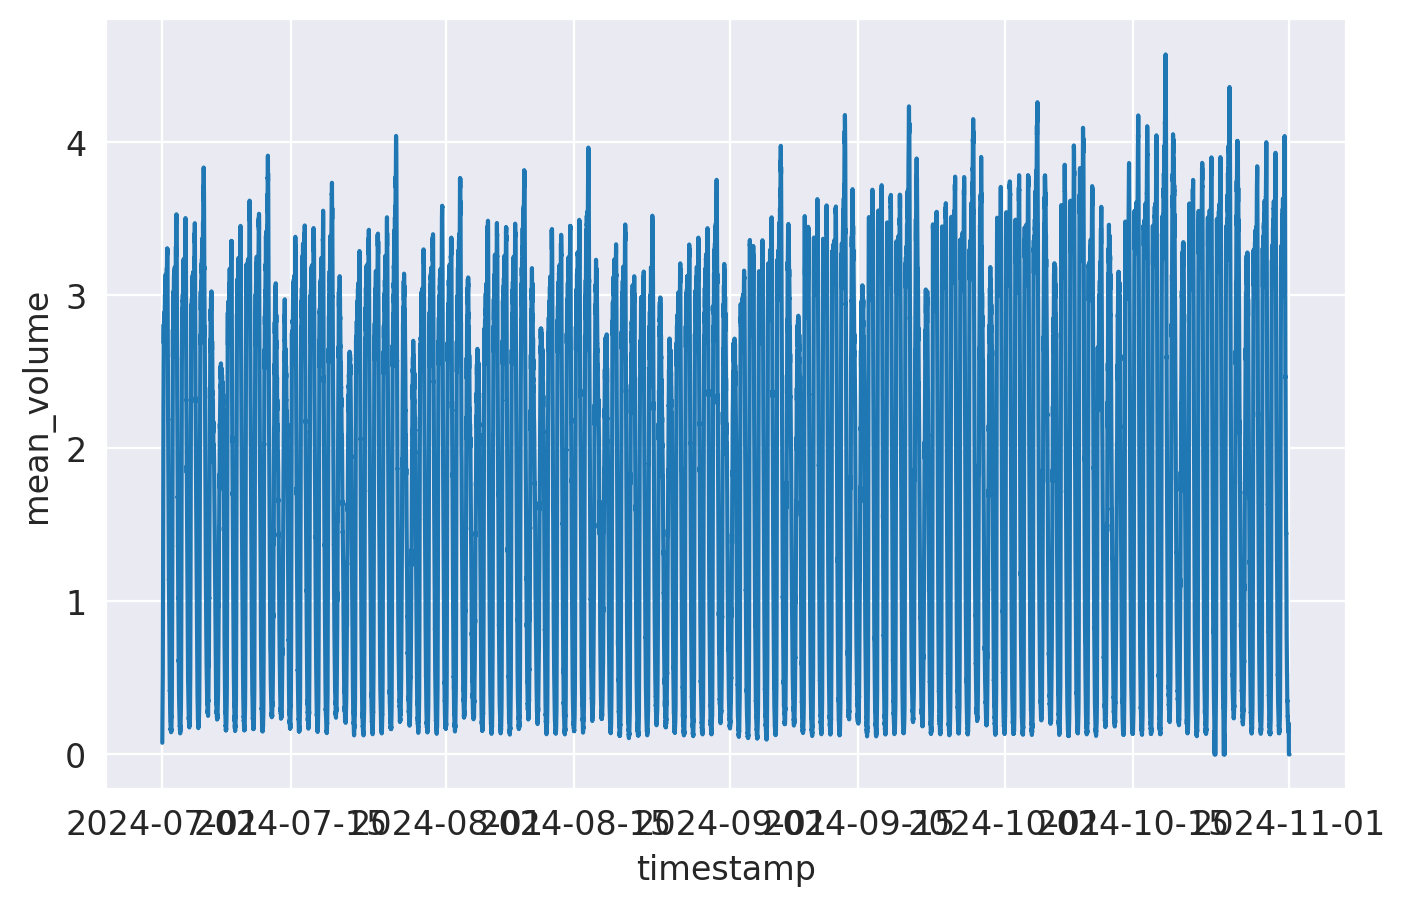

In [16]:
sns.lineplot(
    x=volume_df.select('timestamp').collect()[:, 0],
    y=volume_df.select('mean_volume').collect()[:, 0]
)

In [17]:
import pandas as pd

ts = pd.DataFrame({
    'timestamp': volume_df.select('timestamp').collect()[:, 0],
    'value_0': volume_df.select('mean_volume').collect()[:, 0]
})
ts['timestamp'] = ts['timestamp'].astype('int64')
ts.to_csv('road_volume_series.csv', index=False)

- Утренний час пик: 8:45 (3:45)
- Вечерний час пик: 18:00 (13:00)

Давайте соберём два DataFrame для графа 8 региона:
- рёбра графа
- свойства нод (с информацией по объёму и скорости)

In [18]:
if 'id' not in features_df.collect_schema().names():
    features_df = features_df.with_row_index('id')

edges_df = edges_df.join(
    features_df.select(['id', 'region_id']),
    left_on='source',
    right_on='id',
    how='left'
).with_columns(
    from_region=pl.col('region_id')
).drop('region_id')

edges_df = edges_df.join(
    features_df.select(['id', 'region_id']),
    left_on='target',
    right_on='id',
    how='left'
).with_columns(
    to_region=pl.col('region_id')
).drop('region_id')

edges_df.head().collect()

source,target,from_region,to_region
i64,i64,f64,f64
0,7760,3.0,3.0
0,7761,3.0,3.0
1,5,3.0,3.0
2,6,3.0,3.0
3,7,3.0,3.0


In [19]:
REGION = 8.0

In [20]:
region_edges = edges_df.filter(
    (pl.col("from_region") == REGION) &
    (pl.col("from_region") == pl.col("to_region")
)).drop('from_region', 'to_region').collect()
print(region_edges.shape)
region_edges.head()

(8973, 2)


source,target
i64,i64
796,794
49355,794
796,795
49355,795
795,796


In [21]:
region_features_df = features_df.filter(
    pl.col('region_id') == REGION
).collect()
region_features_df.head()

id,category,edge_type,speed_mode,speed_limit,region_id,can_bind_to_reverse_edge,dismount_bike,has_masstransit_lane,ends_with_crosswalk,ends_with_toll_post,is_in_poor_condition,is_paved,is_restricted_for_trucks,is_toll,access_0,access_1,access_2,access_3,access_4,access_5,length,num_segments,x_coordinate_start,y_coordinate_start,x_coordinate_end,y_coordinate_end,node_id,speed_23:20:00,speed_03:25:00,speed_11:50:00,speed_07:25:00,speed_05:00:00,speed_01:25:00,speed_22:20:00,speed_13:20:00,speed_05:35:00,…,speed_23:50:00,speed_20:25:00,speed_04:55:00,speed_01:20:00,speed_17:20:00,speed_02:15:00,speed_04:10:00,speed_11:05:00,speed_23:10:00,speed_08:05:00,speed_21:55:00,speed_19:25:00,speed_04:20:00,speed_21:15:00,speed_08:55:00,speed_21:50:00,speed_06:55:00,speed_19:35:00,speed_04:00:00,speed_16:35:00,speed_16:30:00,speed_23:55:00,speed_13:40:00,speed_13:35:00,speed_14:30:00,speed_11:15:00,speed_09:45:00,speed_01:55:00,speed_20:40:00,speed_13:30:00,speed_05:45:00,speed_17:00:00,speed_08:30:00,speed_16:40:00,speed_13:45:00,speed_10:40:00,speed
u32,f64,f64,f64,f64,f64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
794,5.0,1.0,1.0,0.0,8.0,true,false,false,false,false,false,true,false,false,true,true,true,true,true,true,72.800003,1.0,60.575049,56.806665,60.574377,56.806125,"""node_794""",23.117037,20.836161,18.435549,18.93751,19.977011,22.992693,24.730695,18.369093,19.673532,…,24.441125,23.495465,20.30596,22.824733,21.028178,22.934538,20.727973,19.100657,23.251076,18.563472,24.412899,22.652799,20.482553,23.416229,19.324584,24.273255,18.580604,22.771914,20.646234,19.96284,20.064453,24.470822,17.442793,17.698362,18.489592,19.039899,18.524237,22.669969,23.095848,17.975121,19.794919,20.451585,19.190317,19.93039,17.515962,18.668865,23.777722
795,5.0,1.0,1.0,0.0,8.0,true,false,false,false,false,false,true,false,false,true,true,true,true,true,true,46.099998,1.0,60.575049,56.806665,60.575474,56.807008,"""node_795""",24.982205,20.820125,20.619229,20.905622,21.552977,21.365067,22.348604,21.46628,20.521025,…,25.035108,24.053828,21.689791,22.199779,21.119101,19.802677,21.628312,20.446527,24.832347,20.67176,19.886123,22.096854,21.821766,21.495081,20.148269,19.573229,20.586914,22.293956,21.452942,20.674009,20.35906,25.010429,20.512025,20.602282,20.282238,20.285873,20.600748,19.575474,23.990713,20.965421,20.308637,21.042234,20.457854,20.665606,20.521624,20.784753,20.396734
796,5.0,1.0,1.0,0.0,8.0,true,false,false,false,false,false,true,false,false,true,true,true,true,true,true,46.099998,1.0,60.575474,56.807008,60.575049,56.806665,"""node_796""",22.627461,20.915224,19.878343,19.734727,20.365977,22.704955,23.956379,19.767582,19.866616,…,23.570028,22.593268,20.804938,22.529167,20.972017,22.522821,20.893219,19.354104,22.514398,19.571472,23.38621,22.135211,20.995307,22.630105,19.284301,23.18468,19.470773,22.398493,20.963615,19.813308,19.821937,23.695943,19.272478,19.336756,19.037328,19.223746,19.867836,22.669698,22.290071,19.46364,19.731524,20.498032,19.443104,20.125113,19.293775,19.274654,22.591893
797,5.0,1.0,1.0,0.0,8.0,true,false,false,false,false,false,true,false,false,true,true,true,true,true,true,48.099998,1.0,60.575474,56.807008,60.575917,56.807365,"""node_797""",25.183265,18.575254,19.94053,19.10884,19.699497,22.753437,21.770726,19.585591,19.062272,…,25.236595,24.154704,19.918663,22.756628,20.998759,19.831118,19.315996,19.447656,25.037732,19.016314,20.046413,22.077526,19.266547,20.840088,18.30268,19.290156,18.930782,22.172044,19.347552,20.159003,19.973062,25.211718,18.644314,18.808759,18.860468,19.274427,19.843612,21.447103,23.926446,18.926399,19.331103,20.875674,18.895163,20.419679,18.487372,19.339683,17.543488
798,5.0,1.0,1.0,0.0,8.0,true,false,false,false,false,false,true,false,false,true,true,true,true,t

Создадим граф из дорог региона с атрибутами

In [22]:
region_features_df = region_features_df.drop('speed')

In [23]:
import networkx as nx


# Шаг 1: Создаем вспомогательный граф для поиска соединённых точек
junction_graph = nx.Graph()

# Добавляем все возможные начальные и конечные точки как вершины
all_edge_ids = region_features_df["id"].to_list()
for edge_id in all_edge_ids:
    start_node = f"{edge_id}_start"
    end_node = f"{edge_id}_end"
    junction_graph.add_node(start_node)
    junction_graph.add_node(end_node)

# Шаг 2: Соединяем точки на основе region_edges
# Каждая строка (s, t) означает, что s_end и t_start - одна и та же точка
for row in region_edges.iter_rows(named=True):
    source_end_node = f"{row['source']}_end"
    target_start_node = f"{row['target']}_start"
    junction_graph.add_edge(source_end_node, target_start_node)
    
# Шаг 3: Находим связные компоненты. Каждая компонента - это одна вершина в нашем финальном графе.
# Создаем словарь-маппинг: временное имя точки -> ID финальной вершины
# ID финальной вершины будет просто номер компоненты (0, 1, 2, ...)
components = nx.connected_components(junction_graph)
node_map = {}
for i, component in enumerate(components):
    final_node_id = i  # ID вершины в итоговом графе
    for temp_node_name in component:
        node_map[temp_node_name] = final_node_id

# print("\n--- Промежуточные результаты ---")
# print("Словарь для сопоставления точек с итоговыми вершинами (node_map):")
# # Для наглядности выведем отсортированно
# for k in sorted(node_map.keys()):
#     print(f"'{k}': {node_map[k]}")

# Шаг 4: Создаем итоговый направленный граф
G = nx.DiGraph()

# Для удобного доступа к атрибутам создадим словарь
# {id: {attr1: val1, ...}}
features_dict = {
    row['id']: {k: v for k, v in row.items() if k != 'id'}
    for row in region_features_df.iter_rows(named=True)
}

# Обходим все исходные рёбра
for edge_id, attributes in features_dict.items():
    # Находим ID начальной и конечной вершины в финальном графе
    start_node_final_id = node_map[f"{edge_id}_start"]
    end_node_final_id = node_map[f"{edge_id}_end"]
    
    # Добавляем ребро в финальный граф со всеми его атрибутами
    # Ребро в нашем финальном графе представляет собой исходное ребро из polars
    G.add_edge(start_node_final_id, end_node_final_id, **attributes, original_id=edge_id)

# --- Проверка результата ---
# print("\n--- Итоговый граф NetworkX ---")
# print(f"Вершины графа G: {list(G.nodes())}")
# print(f"Рёбра графа G (с атрибутами):")
# for u, v, data in G.edges(data=True):
#     print(f"  Ребро ({u} -> {v}), Атрибуты: {data}")



In [24]:
len(G.edges)

4347

Проверим, что граф направленный. То есть там много пар координат, между которыми два ребра (туда и обратно)

In [25]:
from collections import defaultdict
unique_non_directed_edges = defaultdict(int)

for u, v, data in G.edges(data=True):
    assert u != v, 'There are loops'
    edge = (u, v) if u < v else (v, u)
    unique_non_directed_edges[edge] += 1

value_counts = defaultdict(int)
for value in unique_non_directed_edges.values():
    value_counts[value] += 1
value_counts

defaultdict(int, {2: 1723, 1: 901})

In [27]:
nx.write_edgelist(G, f'data/yekaterinburg_region_{REGION}.edgelist')

Сделаем разметку на средние скорости

In [ ]:
from tqdm import tqdm

# 1. Получаем список всех колонок для обработки
all_node_columns = [c for c in speed_df.collect_schema().names() if c.startswith('node_')]
chunk_size = 2000  
all_results = []

print(f"Всего нод для обработки: {len(all_node_columns)}")
num_chunks = (len(all_node_columns) + chunk_size - 1) // chunk_size

# 2. Итерация по чанкам нод
for i in range(num_chunks):
    start_index = i * chunk_size
    end_index = start_index + chunk_size
    node_chunk = all_node_columns[start_index:end_index]
    
    print(f"Обработка чанка {i+1}/{num_chunks} (ноды с {start_index} по {end_index-1})...")

    # 3. Полный ленивый пайплайн для одного чанка
    aggregated_chunk_lazy = (
        speed_df
        # КРИТИЧЕСКАЯ ОПТИМИЗАЦИЯ: читаем только нужные колонки для этого чанка!
        .select(["timestamp"] + node_chunk) 
        .filter(pl.col("timestamp").dt.weekday() <= 5)
        .unpivot(
            index=["timestamp"],
            on=node_chunk, # Unpivot только по 2000 колонкам
            variable_name="node_id",
            value_name="speed"
        )
        .group_by("node_id", pl.col("timestamp").dt.time().alias("time_of_day"))
        .agg(pl.mean("speed").alias("avg_speed"))
    )

    # 4. Collect для одного маленького чанка.
    # Это не должно требовать много памяти.
    aggregated_chunk_df = aggregated_chunk_lazy.collect() 
    all_results.append(aggregated_chunk_df)

# 5. Собираем все результаты вместе
print("Сборка итогового DataFrame из всех чанков...")
aggregated_long_df = pl.concat(all_results, how="vertical")

# 6. Финальный pivot. Он выполняется на уже агрегированных данных и будет быстрым.
print("Выполнение финального pivot...")
mean_speed: pl.DataFrame = aggregated_long_df.pivot(
    index="node_id", 
    on="time_of_day", 
    values="avg_speed"
).sort(pl.col("node_id").str.extract(r"node_(\d+)").cast(pl.Int32))

mean_speed = mean_speed.rename({
    col: f'speed_{col}'
    for col in mean_speed.collect_schema().names()
    if col != 'node_id'
})

print("\nГотово! Форма результирующего DataFrame:", mean_speed.shape)
mean_speed.head()

In [ ]:
# features_df = pl.concat([features_df.collect(), mean_speed.drop()], how="horizontal")
# features_df.write_parquet(
#     'UrbanTrafficBenchmark/city_M_static_features_modified.parquet'
# )
# features_df.head()